# Github Activity Metrics-Commits

**Activity by Repo**

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following commit metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined

In [21]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
import datetime
plt.rcParams['figure.figsize'] = (15, 5)

with open("../config_temp.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['augur', 'grimoirelab']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440, 25448]


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number(s)
#repo_set = [25440]

## Gather and Process Data

### Query

It should be noted that each entry on this table is for files, not commits. So there can be multiple files/rows for each commits  

In [5]:
df_commits = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
                    c.cmt_commit_hash AS commits,
                    c.cmt_id AS file, 
					c.cmt_added AS lines_added,
					c.cmt_removed AS lines_removed,
                    c.cmt_author_date AS date
                FROM
                	repo r,
                    commits c
                WHERE
                	r.repo_id = c.repo_id AND
                    c.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_commits = pd.concat([df_commits, df_current_repo])

df_commits = df_commits.reset_index()
df_commits.drop("index", axis=1, inplace=True)
        
df_commits

,repo_name,commits,file,lines_added,lines_removed,date
0,augur,79ee6429a570b2982fab12a20dea670a858e1141,34605744,2,2,2021-03-24
1,augur,79ee6429a570b2982fab12a20dea670a858e1141,34605745,1,1,2021-03-24
2,augur,574901f5cd8372006cc64ff2b9f14f5470bba4e4,34605767,6,6,2021-03-19
3,augur,7877b0c7937c6242e18ed712d5fb14323d13115f,34605778,2,2,2021-03-24
4,augur,7877b0c7937c6242e18ed712d5fb14323d13115f,34605779,1,1,2021-03-24
...,...,...,...,...,...,...
27673,grimoirelab,fe7ab96bdf7d0187737285af6dc3c08f5c422f14,34556304,6,2,2018-01-19
27674,grimoirelab,ff18ee3474f147c6c3b99997ac79b612fd7a2adc,34556713,2,2,2018-06-04
27675,grimoirelab,ff22f21630e80b67707db0551ca1787de843e403,34556365,1,1,2018-09-10
27676,grimoirelab,ff7bd07014362d6b1b54a7c4de6e70e8412ee1d0,34557194,15,0,2019-04-01


### Data Cleaning

In [6]:
df_commits['date_time'] = pd.to_datetime(df_commits['date'], format= '%Y-%m-%d')

In [7]:
#IF YOU ONLY WANT TO LOOK AT A ONE OF THE REPOS QUERIED 
repo_focus = 'augur'
df_repo_focus = df_commits[df_commits['repo_name'] == repo_focus]
df_repo_focus = df_repo_focus.sort_values(by= "date_time")
df_repo_focus = df_repo_focus.reset_index(drop=True)

In [8]:
df_repo_focus

,repo_name,commits,file,lines_added,lines_removed,date,date_time
0,augur,c1c780958deb790fd40520873fdf8eee8e9988d9,34595109,17,1,2017-01-05,2017-01-05
1,augur,c1c780958deb790fd40520873fdf8eee8e9988d9,34595110,1,1,2017-01-05,2017-01-05
2,augur,9c742edec6169dbd8423c96c07c4725499ebaa6e,34586512,42,1,2017-01-10,2017-01-10
3,augur,4d67b9758af01f1789edab9564c5f876c3665e38,34586047,1,6,2017-01-10,2017-01-10
4,augur,9c742edec6169dbd8423c96c07c4725499ebaa6e,34586503,4,1,2017-01-10,2017-01-10
...,...,...,...,...,...,...,...
25842,augur,cb0bce873c5ff578a8b3c818f36ce7efe94a5e0e,34684610,5,0,2021-07-25,2021-07-25
25843,augur,70f60c931f3dd764579c83032dad10f24456690f,34684604,1,1,2021-07-26,2021-07-26
25844,augur,fa7e9767664c46865ec09b7479b89431fa0fe207,34684818,0,0,2021-08-01,2021-08-01
25845,augur,3a253df3838f2103ce6ed0de0a87e1bea4904820,34684343,0,0,2021-08-01,2021-08-01


## Number of commits 

In [9]:
# We will fetch all the unique commit IDs and drop the redundant ones
df_commits_unique = df_repo_focus.drop(columns = ['file'])
agg_fun = {'repo_name': 'first',  'commits': 'first', 'lines_added': 'sum', 'lines_removed': 'sum', 
                         'date': 'first', 'date_time': 'first'}
df_commits_unique = df_commits_unique.groupby(df_commits_unique['commits']).aggregate(agg_fun)
df_commits_unique = df_commits_unique.reset_index(drop=True)

### By Day 

In [30]:
two_years = datetime.datetime.now() - datetime.timedelta(days=2*365)
repo_daily_commits = df_commits_unique[df_commits_unique['date_time'] > two_years]

repo_daily_commits = repo_daily_commits['date_time'].groupby(repo_daily_commits.date_time.dt.to_period("D")).agg('count')

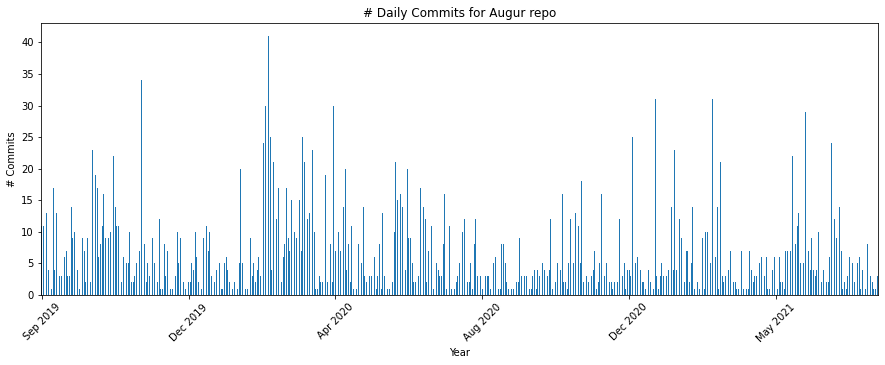

In [31]:
repo_daily_commits.plot.bar()

plt.xlabel("Days")
plt.ylabel("# Commits")
locs, labels = plt.xticks()
N = 90
plt.xticks(locs[::N], repo_daily_commits.index[::N].strftime('%b %Y'))
plt.xticks(rotation=45)
plt.title("# Daily Commits for "+repo_focus.capitalize() +" repo")
plt.show()

### By Week

In [13]:
repo_week_commits = df_commits_unique['date_time'].groupby(df_commits_unique.date_time.dt.to_period("W")).agg('count')

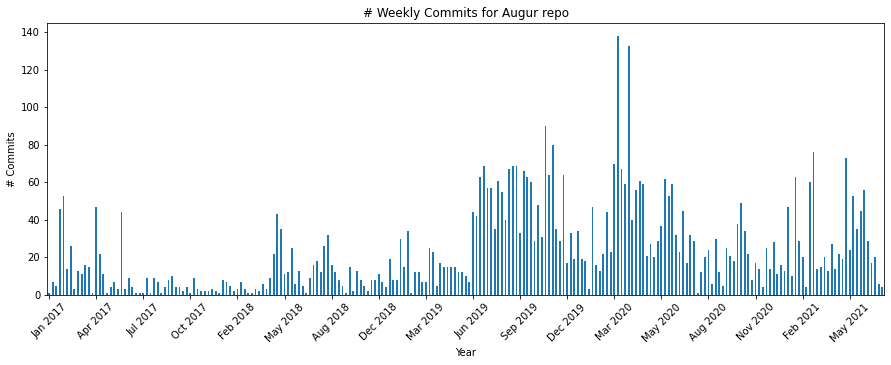

In [14]:
repo_week_commits.plot.bar()

plt.xlabel("Year")
plt.ylabel("# Commits")
locs, labels = plt.xticks()
N = 13
plt.xticks(locs[::N], repo_week_commits.index[::N].strftime('%b %Y'))
plt.xticks(rotation=45)
plt.title("# Weekly Commits for " + repo_focus.capitalize() + " repo")
plt.show()

### By Month

In [15]:
repo_monthy_commits = df_commits_unique['date_time'].groupby(df_commits_unique.date_time.dt.to_period("M")).agg('count')

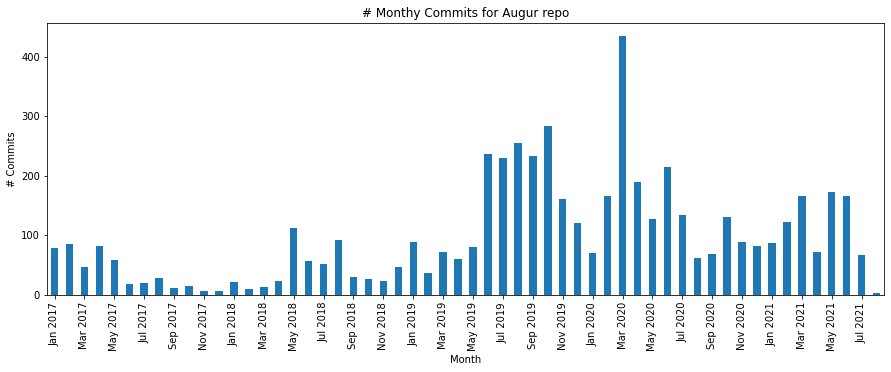

In [35]:
repo_monthy_commits.plot.bar()
plt.xlabel("Month")
locs, labels = plt.xticks()
N = 2
plt.xticks(locs[::N], repo_monthy_commits.index[::N].strftime('%b %Y'))
plt.ylabel("# Commits")
plt.title("# Monthy Commits for " + repo_focus.capitalize() + " repo")
plt.show()

## Number of lines per commit

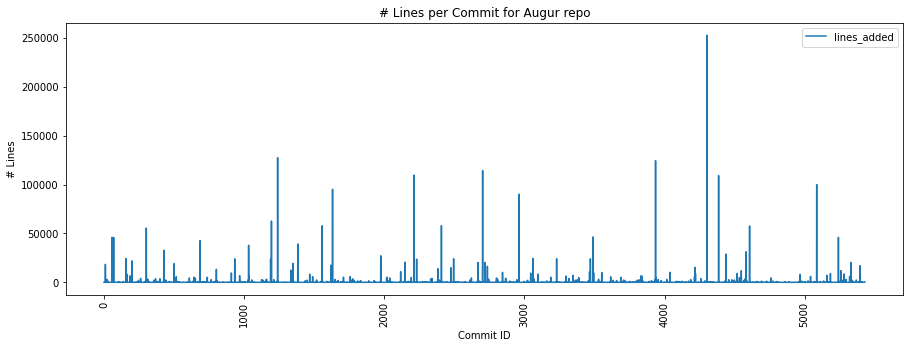

In [17]:
df_lines_repo = df_commits_unique[["commits", "lines_added"]]
df_lines_repo.plot()

plt.xlabel("Commit ID")
plt.ylabel("# Lines")
plt.title("# Lines per Commit for "+ repo_focus.capitalize() + " repo")
plt.xticks(rotation=90)
plt.show()

In [18]:
df_commits_unique.describe()

,lines_added,lines_removed
count,5431.000000,5431.000000
mean,581.224636,590.132020
std,6150.904575,7409.079865
min,0.000000,0.000000
25%,0.000000,0.000000
50%,3.000000,1.000000
75%,33.000000,14.000000
max,252656.000000,321009.000000


## Number of lines per file

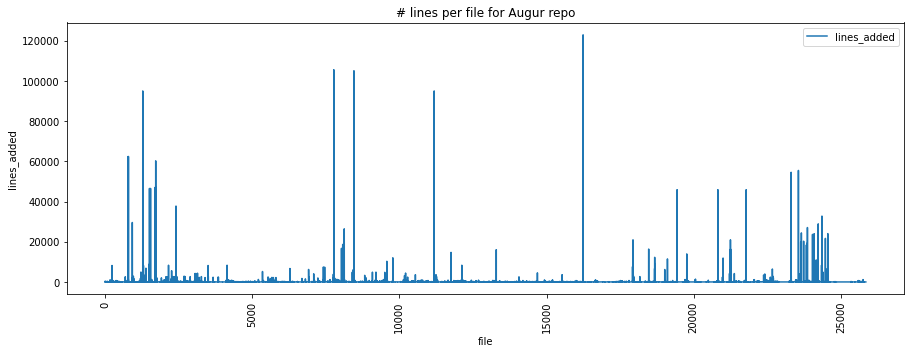

In [19]:
df_repo_focus[[ "lines_added"]].plot()

plt.xlabel("file")
plt.ylabel("lines_added")
plt.title("# lines per file for "+ repo_focus.capitalize() + " repo")
plt.xticks(rotation=90)
plt.show()